In [8]:
# 基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 中文词云分析
import jieba
from wordcloud import WordCloud

# 可视化
import plotly.express as px

# 文本分析与聚类
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 忽略警告信息
warnings.filterwarnings("ignore")


In [10]:
#读取数据
df= pd.read_csv('job_esg_data.csv',encoding="utf-8")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   岗位名词       400 non-null    object 
 1   岗位类别       400 non-null    object 
 2   招聘人数       400 non-null    int64  
 3   经验要求       400 non-null    object 
 4   学历要求       400 non-null    object 
 5   平均月薪（万）    400 non-null    float64
 6   薪资下限（万/月）  400 non-null    float64
 7   薪资上限（万/月）  400 non-null    float64
 8   岗位描述       400 non-null    object 
 9   城市         400 non-null    object 
 10  区          400 non-null    object 
 11  招聘单位       400 non-null    object 
 12  单位类别       400 non-null    object 
 13  企业规模       400 non-null    object 
 14  所属行业       400 non-null    object 
 15  备注一        302 non-null    object 
 16  备注二        248 non-null    object 
dtypes: float64(3), int64(1), object(13)
memory usage: 53.3+ KB


,岗位名词,岗位类别,招聘人数,经验要求,学历要求,平均月薪（万）,薪资下限（万/月）,薪资上限（万/月）,岗位描述,城市,区,招聘单位,单位类别,企业规模,所属行业,备注一,备注二
0,绿色金融数据分析实习生,实习,1,1年以下,硕士,0.2640,0.220,0.308,职位描述实习证明数据分析模型设计SPSS金融数据分析 工作职责： 1.负责公司ESG评级...,北京,丰台,东方金诚信用管理(北京)有限公司,国企,20-99人,证券/期货,模型设计,SPSS
1,绿色金融项目科研助理,实习,1,1年以下,本科,0.3300,0.220,0.440,职位描述可转正实习证明碳中和绿色金融新能源学术/科研岗位职责： 1、项目相关行业研究分析及...,北京,朝阳,北京浩华浩信资产管理顾问有限公司,外商独资,20-99人,咨询服务,绿色金融,NaN
2,中国节能协会绿色低碳金融产业委员会产业部主任,全职,1,5-10年,硕士,1.9000,1.300,2.500,职位描述环保咨询能源咨询节能项目咨询社团/组织/社会保障一、岗位职责\r\n1.组织开展有关...,北京,西城,国发节能环保发展集团有限公司,股份制企业,20-99人,环保,能源咨询,节能项目咨询
3,Campaigner_Green Finance(J10145),全职,1,1年以下,本科,1.6000,1.500,1.700,职位描述绿色金融气候金融转型金融 OVERVIEW \r\n 绿色和平绿色与转型金融项目组正...,北京,东城,GREENPEACE EAST ASIA,社会团体,100-299人,社团/组织/社会保障,气候金融,转型金融
4,博士后工作站科研人员,全职,3,1年以下,博士,2.1875,1.875,2.500,职位描述绿色金融评级行业债券市场新能源一、博士后申请条件\r\n \r\n1. 具有海内外的...,北京,八里庄,大公国际资信评估有限公司,国企,500-999人,证券/期货,评级行业,债券市场


In [12]:
df.duplicated().sum()

103

In [14]:
df.drop_duplicates(keep='first',inplace=True) #去除重复记录
df.duplicated().sum()

0

In [18]:
# 假设df是你的DataFrame，列名为“岗位描述”
def split_description(text):
    if pd.isna(text):
        return pd.Series([None, None])
    
    # 使用常见关键词进行正则匹配（可以根据你的数据进一步微调）
    match = re.search(r'(岗位职责|职位描述)[：:\s]?(.*?)(任职要求|岗位要求|要求|资格|和经验：|专业背景：|QUALIFICATIONS|满期待|希望你：|经验：|条件|Certifications|REQUIREMENTS|要求：|需要)[：:\s]?(.*)', text, re.S)
    if match:
        return pd.Series([match.group(2).strip(), match.group(4).strip()])
    else:
        return pd.Series([text.strip(), None])  # 无法匹配时，整个内容作为职位描述

# 应用拆分
df[['职位描述', '任职要求']] = df['岗位描述'].apply(split_description)
df

,岗位名词,岗位类别,招聘人数,经验要求,学历要求,平均月薪（万）,薪资下限（万/月）,薪资上限（万/月）,岗位描述,城市,区,招聘单位,单位类别,企业规模,所属行业,备注一,备注二,职位描述,任职要求
0,绿色金融数据分析实习生,实习,1,1年以下,硕士,0.2640,0.220,0.308,职位描述实习证明数据分析模型设计SPSS金融数据分析 工作职责： 1.负责公司ESG评级...,北京,丰台,东方金诚信用管理(北京)有限公司,国企,20-99人,证券/期货,模型设计,SPSS,实习证明数据分析模型设计SPSS金融数据分析 工作职责： 1.负责公司ESG评级相关产品...,1.计算机应用、统计学或其他数据分析模型相关专业在校研一、研二生；有基金管理、数据建模相关实...
1,绿色金融项目科研助理,实习,1,1年以下,本科,0.3300,0.220,0.440,职位描述可转正实习证明碳中和绿色金融新能源学术/科研岗位职责： 1、项目相关行业研究分析及...,北京,朝阳,北京浩华浩信资产管理顾问有限公司,外商独资,20-99人,咨询服务,绿色金融,NaN,可转正实习证明碳中和绿色金融新能源学术/科研岗位职责： 1、项目相关行业研究分析及总结归纳...,1、本科及以上学历，金融、政策、环境、AI、双碳相关专业或有相关领域实习经验者优先； 2、...
2,中国节能协会绿色低碳金融产业委员会产业部主任,全职,1,5-10年,硕士,1.9000,1.300,2.500,职位描述环保咨询能源咨询节能项目咨询社团/组织/社会保障一、岗位职责\r\n1.组织开展有关...,北京,西城,国发节能环保发展集团有限公司,股份制企业,20-99人,环保,能源咨询,节能项目咨询,环保咨询能源咨询节能项目咨询社团/组织/社会保障一、岗位职责\r\n1.组织开展有关绿色低碳...,1.环境科学、环境工程、能源、能效、公共政策、公共管理等相关领域硕士研究生以上学历。\r\n...
3,Campaigner_Green Finance(J10145),全职,1,1年以下,本科,1.6000,1.500,1.700,职位描述绿色金融气候金融转型金融 OVERVIEW \r\n 绿色和平绿色与转型金融项目组正...,北京,东城,GREENPEACE EAST ASIA,社会团体,100-299人,社团/组织/社会保障,气候金融,转型金融,绿色金融气候金融转型金融 OVERVIEW \r\n 绿色和平绿色与转型金融项目组正在招募一...,• Bachelor degree or above in related field su...
4,博士后工作站科研人员,全职,3,1年以下,博士,2.1875,1.875,2.500,职位描述绿色金融评级行业债券市场新能源一、博士后申请条件\r\n \r\n1. 具有海内外的...,北京,八里庄,大公国际资信评估有限公司,国企,500-999人,证券/期货,评级行业,债券市场,绿色金融评级行业债券市场新能源一、博士后申请,1. 具有海内外的博士学位或应届博士研究生；\r\n \r\n2. 具有金融工程、数学、经济...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,减排项目经理CCER,全职,1,1年以下,本科,1.2500,1.000,1.500,职位描述低碳碳中和碳交易CCER环保 \r\n职位描述：\r\n \r\n1. 负责公司...,杭州,滨江,杭州超腾能源技术股份有限公司,民营,100-299人,环保,碳中和,低碳,低碳碳中和碳交易CCER环保 \r\n职位描述：\r\n \r\n1. 负责公司CCER...,1、理工科或林学、农业、经济、管理、城市规划等相关专业或行业背景，本科以上学历，有留学背景优...
396,碳交易核查员（郑州）,全职,5,1年以下,本科,1.0000,0.800,1.200,职位描述碳核算绿色低碳环保岗位职责：\r\n1、国内碳交易排放第三方核查及报告编写；\r\n...,郑州,金水,华夏认证中心有限公司,民营,100-299人,检测/认证,绿色低碳,碳核算,碳核算绿色低碳环保岗位职责：\r\n1、国内碳交易排放第三方核查及报告编写；\r\n2、可持...,1、环境工程、环境科学、热能工程、发（供）电、电气、水泥、钢铁、石油天然气工程、化工、冶金等...
397,碳交易员,全职,1,1年以下,大专,0.4500,0.400,0.500,职位描述咨询服务环保岗位职责：\r\n1. 负责研究碳交易市场动态，分析碳排放权行业相关政策...,郑州,管城,河南神木建设集团有限公司,民营,20-99人,工程施工,NaN,NaN,咨询服务环保岗位职责：\r\n1. 负责研究碳交易市场动态，分析碳排放权行业相关政策、价格趋...,1. 大专及以上学历，环境科学、能源管理、金融等相关专业背景。\r\n2. 具备良好的数据分...
398,双碳项目经理,全职,1,3-5年,本科,1.0500,0.800,1.300,职位描述碳行业碳交易CCERCCUSVCSCDP工作职责：\r\n1、负责公司碳减排方案开发...,南昌,青山湖,江西中节能峰和环境有限公司,其它,20-99人,环保,碳交易,碳行业,碳行业碳交易CCERCCUSVCSCDP工作职责：\r\n1、负责公司碳减排方案开发和碳交易...,1、环境、能源等相关专业本科以上学历； \r\n2、2年以上碳相关行业经历，涉及CCER以...


In [65]:
# 检查“任职要求”字段中的空值，并筛选出这些行  
empty_rows = df[df['任职要求'].isnull()]  
  
empty_rows

,岗位名词,岗位类别,招聘人数,经验要求,学历要求,平均月薪（万）,薪资下限（万/月）,薪资上限（万/月）,岗位描述,城市,区,招聘单位,单位类别,企业规模,所属行业,备注一,备注二,职位描述,任职要求
122,"Project Manager, ESG - GHG",全职,1,5-10年,硕士,1.50,1.0,2.0,职位描述可再生能源、房地产、金融英文好Job Description:\r\nPrimary...,上海,静安,上海环顺光电科技有限公司,外商独资,100-299人,咨询服务,NaN,NaN,职位描述可再生能源、房地产、金融英文好Job Description:\r\nPrimary...,None
124,影响力投资（ESG投资）,全职,1,10年以上,硕士,6.00,5.0,7.0,职位描述影响力投资ESG投资社会责任数字经济新消费能源与工业生物经济1. 持续跟踪更新可持续...,上海,虹口,北京煜川企业管理发展有限公司,民营,20-99人,投资/融资,ESG投资,社会责任,职位描述影响力投资ESG投资社会责任数字经济新消费能源与工业生物经济1. 持续跟踪更新可持续...,None
135,高级经理,全职,1,3-5年,硕士,1.15,0.8,1.5,职位描述环保ESG低碳环保1.研究生及以上学历，金融、经济、环境、能源等相关专业；\r\n2...,上海,浦东,联合赤道环境评价股份有限公司,民营,300-499人,环保,ESG,低碳,职位描述环保ESG低碳环保1.研究生及以上学历，金融、经济、环境、能源等相关专业；\r\n2...,None
160,ESG经理(J10492),全职,1,5-10年,硕士,2.40,1.8,3.0,职位描述碳排放ESG1. 战略规划与落地：制定并实施符合公司业务特点的ESG战略，推动环境、...,合肥,高新区,安徽华恒生物科技股份有限公司,股份制企业,1000-9999人,生物工程,ESG,NaN,职位描述碳排放ESG1. 战略规划与落地：制定并实施符合公司业务特点的ESG战略，推动环境、...,None
162,ESG经理,全职,1,10年以上,大专,2.00,1.5,2.5,职位描述环保1、承接集团ESG战略目标，负责ESG项目推进及落地执行，规划集团生产ESG行动...,泉州,晋江市,安踏体育用品集团有限公司,民营,10000人以上,纺织业/服饰产品加工制造,NaN,NaN,职位描述环保1、承接集团ESG战略目标，负责ESG项目推进及落地执行，规划集团生产ESG行动...,None
272,二氧化碳减排及资源化利用工程师,全职,2,1年以下,博士,3.25,2.5,4.0,职位描述固废处理工艺化工化学原料/化学制品1.负责先进的CO2捕集利用技术开发，包括：CO2...,天津,武清,特变电工科技投资有限公司,上市公司,100-299人,证券/期货,NaN,NaN,职位描述固废处理工艺化工化学原料/化学制品1.负责先进的CO2捕集利用技术开发，包括：CO2...,None
273,碳核查/足迹审核员,全职,1,1年以下,本科,0.80,0.6,1.0,职位描述ISO45001CCAA碳中和碳核查外审证书环保1、本科及以上学历，电气、暖通、热能...,天津,和平,联合赤道环境评价股份有限公司,民营,300-499人,环保,CCAA,碳中和,职位描述ISO45001CCAA碳中和碳核查外审证书环保1、本科及以上学历，电气、暖通、热能...,None
313,战略研究岗（可持续发展/气候变化）,全职,1,10年以上,本科,2.75,2.5,3.0,职位描述战略研究可持续发展气候变化1.组织或独立开展气候变化与可持续发展相关领域的创新战略研...,上海,虹口,北京煜川企业管理发展有限公司,民营,20-99人,投资/融资,战略研究,可持续发展,职位描述战略研究可持续发展气候变化1.组织或独立开展气候变化与可持续发展相关领域的创新战略研...,None
394,双碳交易员/碳资产管理,全职,2,3-5年,本科,1.50,1.0,2.0,职位描述节能咨询服务碳咨询碳资产管理环保1.参与组织碳盘查、碳中和规划、碳配额资产管理、国内...,绍兴,诸暨市,浙江菲达环保科技股份有限公司,股份制企业,1000-9999人,环保,碳咨询,节能咨询服务,职位描述节能咨询服务碳咨询碳资产管理环保1.参与组织碳盘查、碳中和规划、碳配额资产管理、国内...,None


***1、数据可视化***

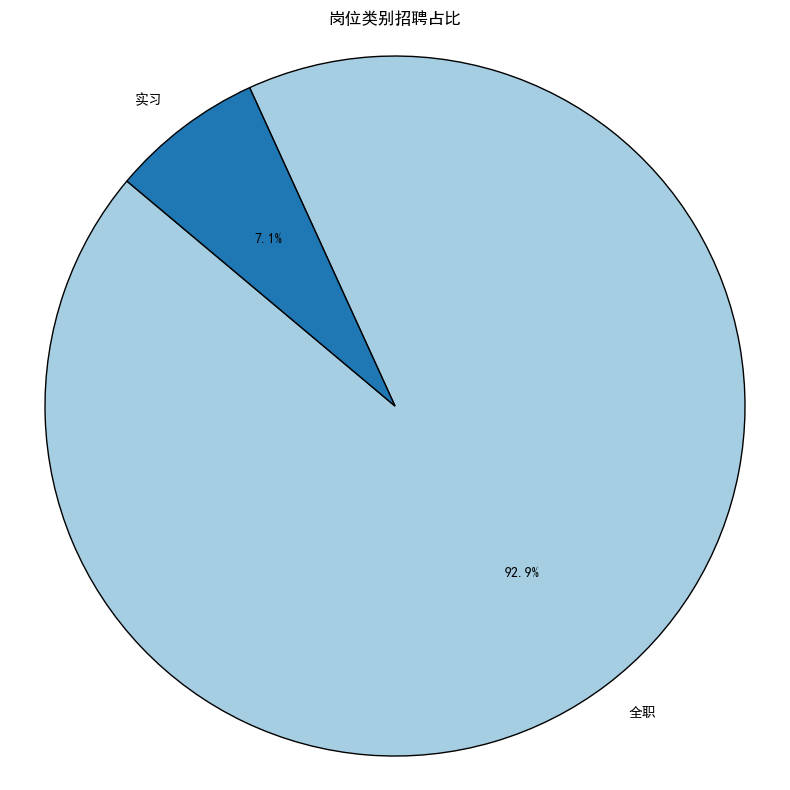

In [73]:
#第一阶段基础数据可视化
#岗位分类饼图
# 设置中文字体（适配中文显示）
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 统计岗位类别数量
job_category_counts = df['岗位类别'].value_counts()

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(job_category_counts, 
        labels=job_category_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=plt.cm.Paired.colors, 
        wedgeprops={'edgecolor': 'black'})

plt.title("岗位类别招聘占比")
plt.axis('equal')  # 保证为圆形
plt.tight_layout()
plt.show()

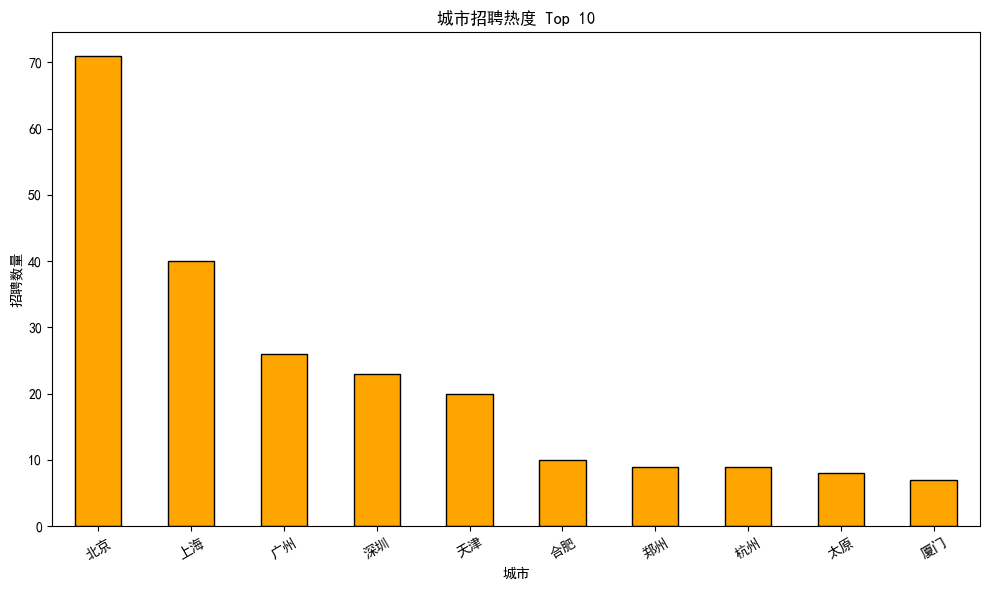

In [77]:
# 统计每个城市的招聘数量，并取前10名
top_cities = df['城市'].value_counts().head(10)

# 绘图
plt.figure(figsize=(10, 6))
top_cities.plot(kind='bar', color='orange', edgecolor='black')

plt.title("城市招聘热度 Top 10")
plt.xlabel("城市")
plt.ylabel("招聘数量")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

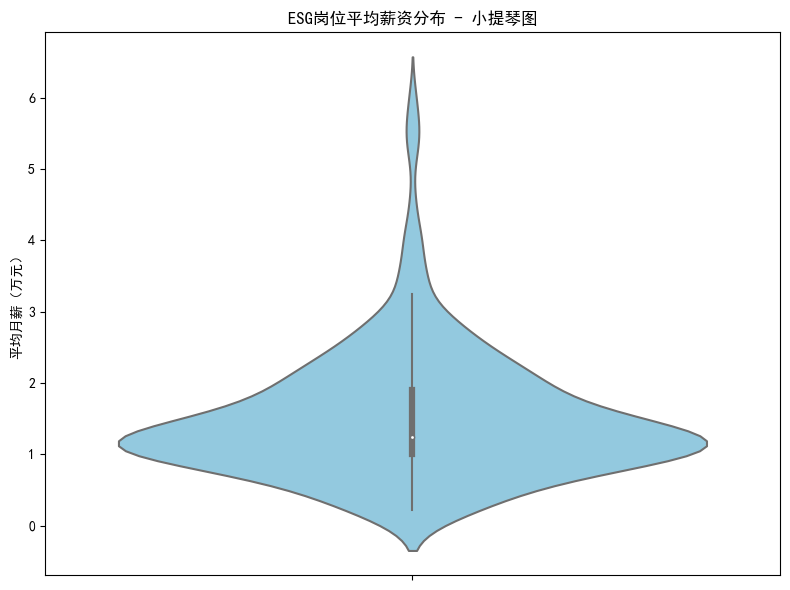

In [75]:
# 仅展示平均薪资分布
plt.figure(figsize=(8, 6))
sns.violinplot(y=df['平均月薪（万）'], inner='box', color='skyblue')
plt.title("ESG岗位平均薪资分布 - 小提琴图")
plt.ylabel("平均月薪（万元）")
plt.tight_layout()
plt.show()

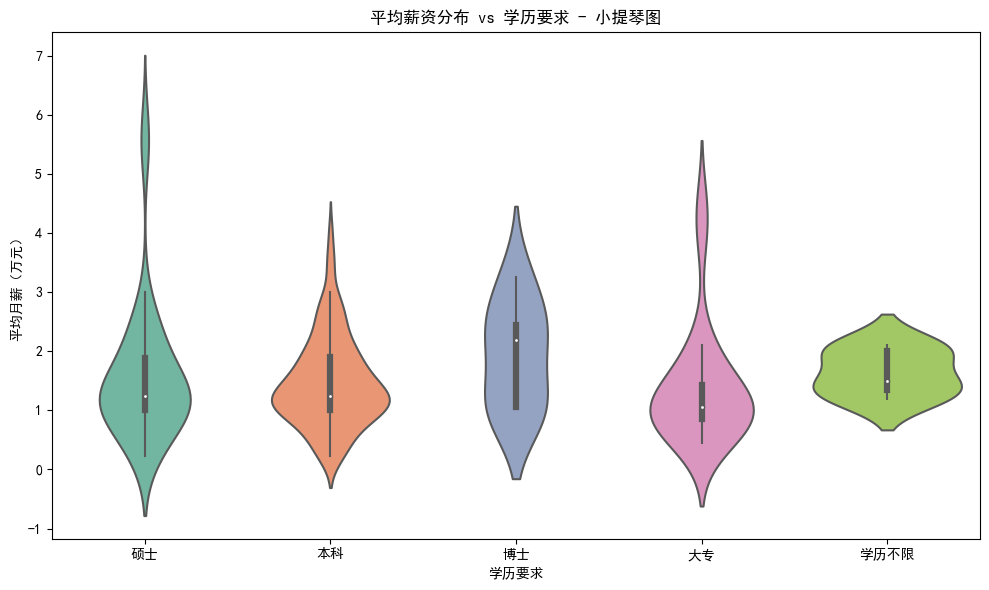

In [79]:
#按学历要求：
plt.figure(figsize=(10, 6))
sns.violinplot(x='学历要求', y='平均月薪（万）', data=df, palette='Set2', inner='box')
plt.title("平均薪资分布 vs 学历要求 - 小提琴图")
plt.xlabel("学历要求")
plt.ylabel("平均月薪（万元）")
plt.tight_layout()
plt.show()

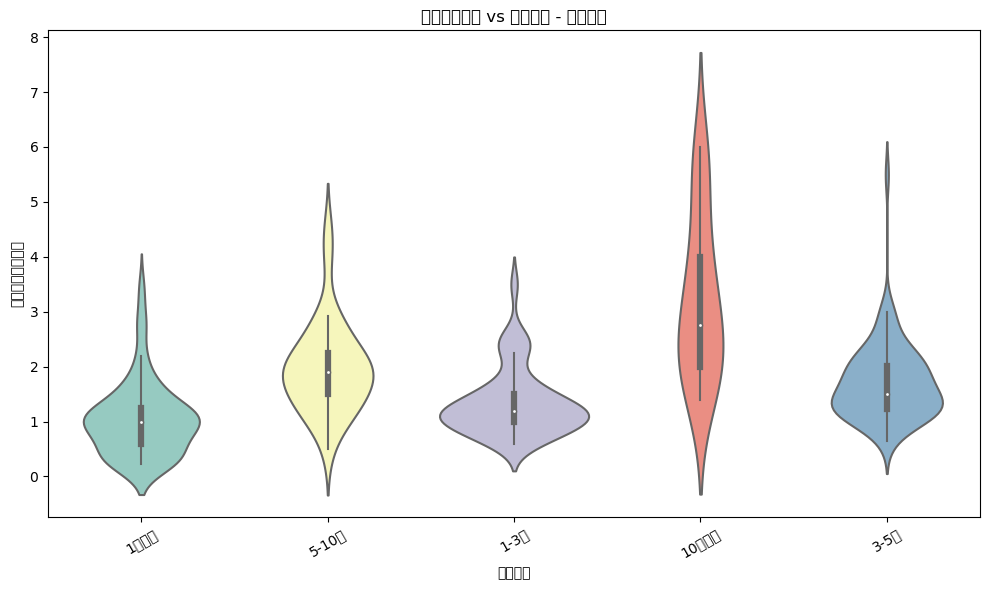

In [20]:
#按经验要求
plt.figure(figsize=(10, 6))
sns.violinplot(x='经验要求', y='平均月薪（万）', data=df, palette='Set3', inner='box')
plt.title("平均薪资分布 vs 经验要求 - 小提琴图")
plt.xlabel("经验要求")
plt.ylabel("平均月薪（万元）")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

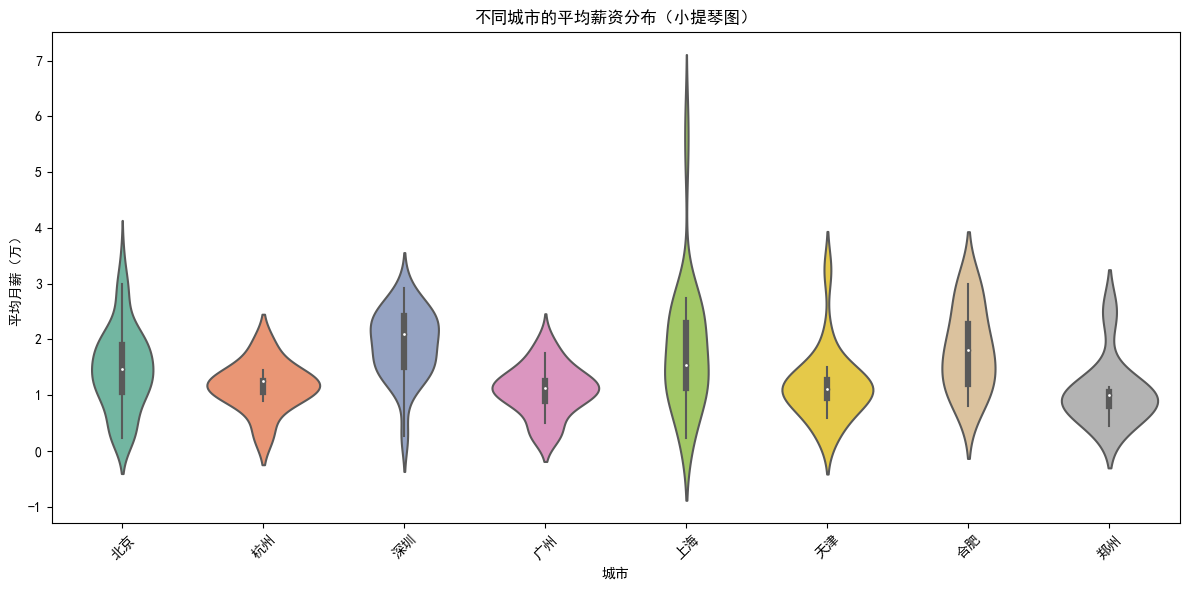

In [83]:
# 按城市统计数量，取招聘数量最多的前8个城市
top_cities = df['城市'].value_counts().nlargest(8).index
df_city_filtered = df[df['城市'].isin(top_cities)]

# 画小提琴图
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_city_filtered, x='城市', y='平均月薪（万）', palette='Set2')

plt.title('不同城市的平均薪资分布（小提琴图）')
plt.ylabel('平均月薪（万）')
plt.xlabel('城市')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

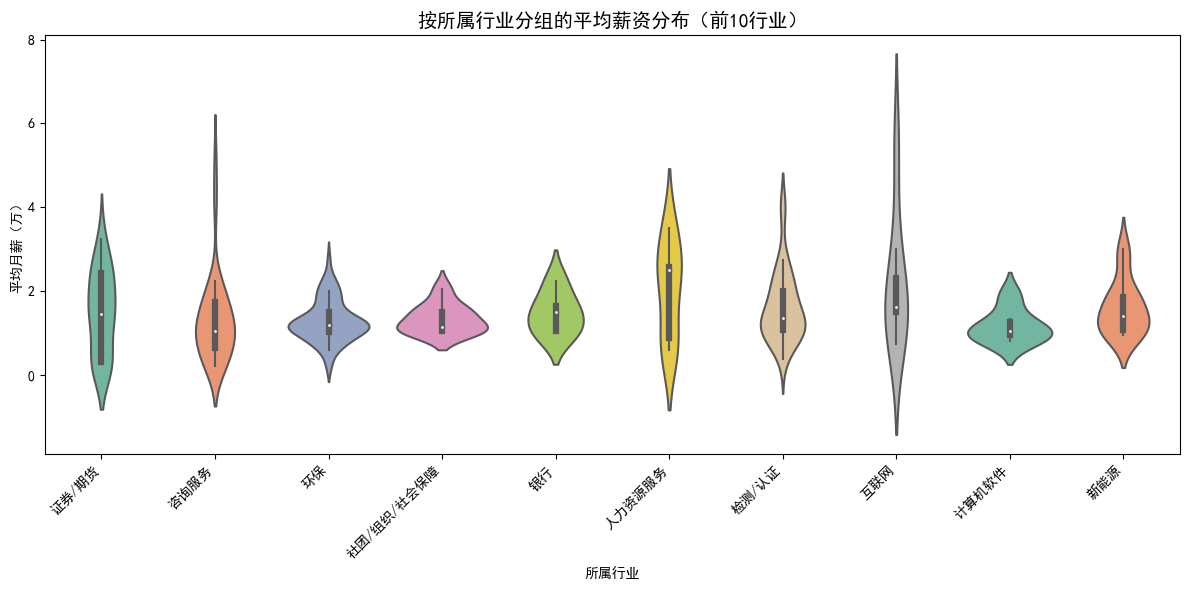

In [85]:
# 选择招聘数最多的前10个行业
top_industries = df['所属行业'].value_counts().nlargest(10).index
df_top = df[df['所属行业'].isin(top_industries)]

# 设置画图风格
plt.figure(figsize=(12, 6))

# 绘制小提琴图
sns.violinplot(
    data=df_top,
    x='所属行业',
    y='平均月薪（万）',
    palette='Set2'
)

plt.title('按所属行业分组的平均薪资分布（前10行业）', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('所属行业')
plt.ylabel('平均月薪（万）')
plt.tight_layout()
plt.show()

In [87]:
import matplotlib.font_manager as fm
for font in fm.fontManager.ttflist:
    if 'Hei' in font.name or 'YaHei' in font.name:
        print(font.name, font.fname)

Microsoft JhengHei C:\Windows\Fonts\msjhbd.ttc
SimHei C:\Windows\Fonts\simhei.ttf
Microsoft JhengHei C:\Windows\Fonts\msjh.ttc
Microsoft YaHei C:\Windows\Fonts\msyhbd.ttc
Microsoft YaHei C:\Windows\Fonts\msyhl.ttc
Microsoft YaHei C:\Windows\Fonts\msyh.ttc
Microsoft JhengHei C:\Windows\Fonts\msjhl.ttc


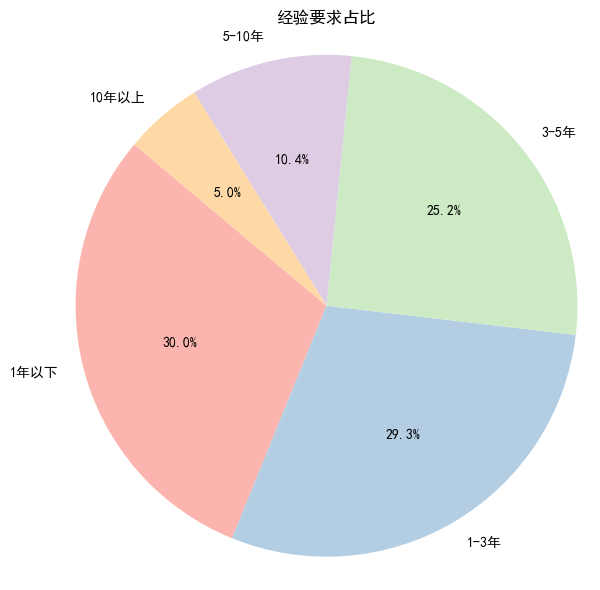

In [91]:
# ===== 经验要求占比 =====
experience_ratio = df['经验要求'].value_counts(normalize=True) * 100
experience_ratio = experience_ratio.round(2)

# 绘制经验要求饼图
plt.figure(figsize=(6, 6))
plt.pie(
    experience_ratio,
    labels=experience_ratio.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel1.colors
)
plt.title('经验要求占比')
plt.axis('equal')
plt.tight_layout()
plt.show()

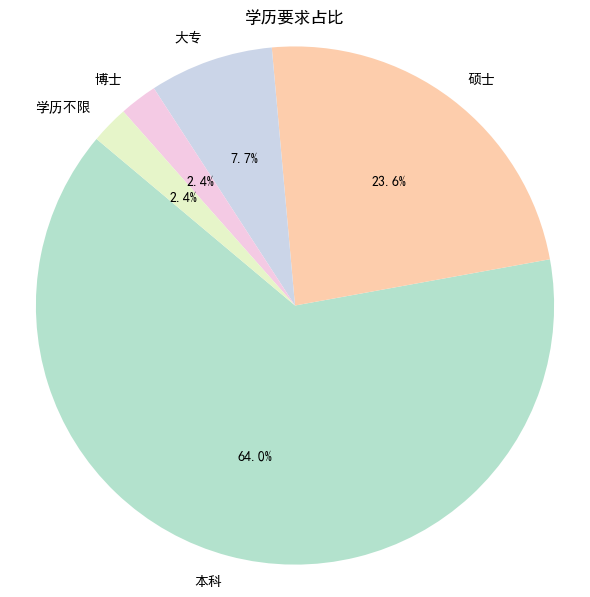

In [93]:
# ===== 学历要求占比 =====
education_ratio = df['学历要求'].value_counts(normalize=True) * 100
education_ratio = education_ratio.round(2)

# 绘制学历要求饼图
plt.figure(figsize=(6, 6))
plt.pie(
    education_ratio,
    labels=education_ratio.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel2.colors
)
plt.title('学历要求占比')
plt.axis('equal')
plt.tight_layout()
plt.show()

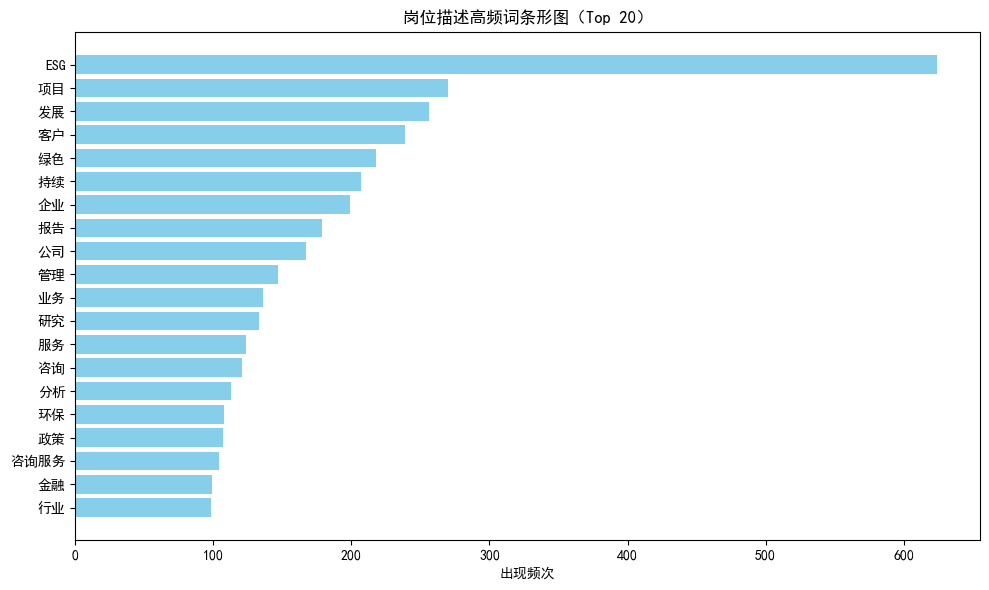

In [95]:
# 拼接所有岗位描述文本
text = ' '.join(df['职位描述'].dropna().astype(str))

# 中文分词
words = jieba.lcut(text)

# 停用词表
stopwords = set([
    '、', '的', '和','职位描述','岗位职责','','and', '等', '我们', '工作', '相关', '以及', '具有', '进行', '要求', '能力', '以上', '岗位',
    '负责', '熟悉', '优先', '经验', '完成', '参与', '能够', '任职', '团队', '提供', '根据', '具备', '协助'
])

# 过滤掉长度小于等于1、停用词和空字符串
filtered_words = [w for w in words if len(w) > 1 and w not in stopwords and w.strip() != '']

# 统计词频
word_counts = Counter(filtered_words)

# 再获取前20
top_words = word_counts.most_common(20)

# 转换为 DataFrame 方便绘图
top_df = pd.DataFrame(top_words, columns=['词语', '频次'])

# 绘图
plt.figure(figsize=(10, 6))
plt.barh(top_df['词语'], top_df['频次'], color='skyblue')
plt.xlabel('出现频次')
plt.title('岗位描述高频词条形图（Top 20）')
plt.gca().invert_yaxis()  # 频率高的在上面
plt.tight_layout()
plt.show()


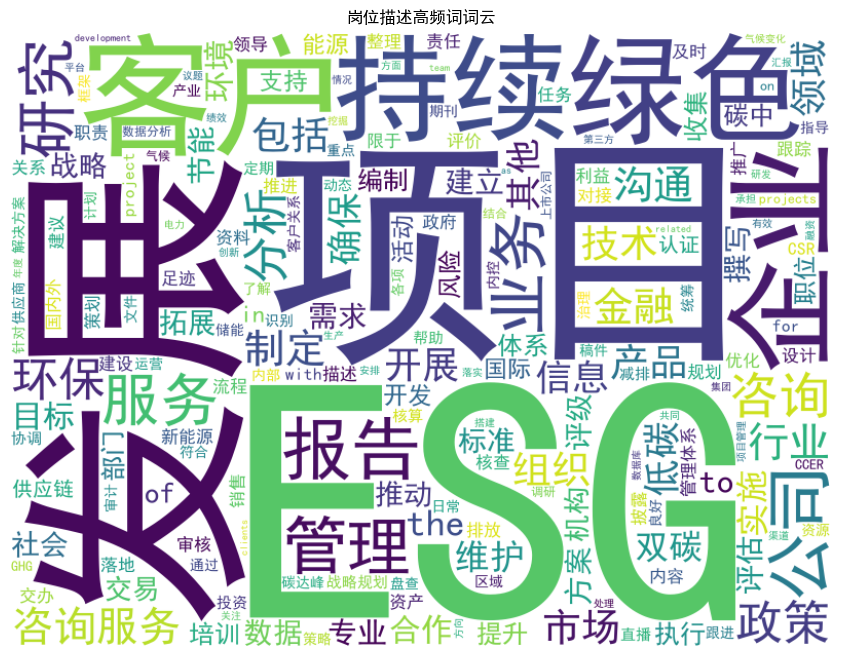

In [122]:
# 转换为字典格式，词云库需要这种格式
word_freq = dict(top_words)

# 生成词云
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 设置词云参数
wordcloud = WordCloud(
    font_path='simhei.ttf',  # 指定中文字体路径，确保能显示中文
    background_color='white',  # 背景颜色
    width=800,  # 宽度
    height=600,  # 高度
    max_words=200  # 最大显示词数
).generate_from_frequencies(word_freq)

# 绘制词云图
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.title('岗位描述高频词词云')
plt.show()

In [99]:
texts = df['职位描述'].dropna().astype(str)

# 停用词（可以根据需求扩展）
stopwords = set(['的', '和', '等', '具有', '及', '工作', '我们', '要求', '岗位', '以上', '相关'])

# 分词并统计
all_words = []
for text in texts:
    words = jieba.lcut(text)
    words = [w for w in words if len(w) > 1 and w not in stopwords]
    all_words.extend(words)

word_freq = Counter(all_words)

In [101]:
# 预设的技能/证书关键词（可以根据语料手动扩充）
skills_keywords = [
    'CFA', 'CPA', 'FRM', '中级会计师', '注册会计师', '基金从业', '证券从业',
    'Excel', 'Python', 'PPT', 'PowerPoint', '数据分析', '风控',
    '审计', '合规', '估值', 'ESG', '碳排放', '双碳', '碳管理', '建模', 'SQL',
    '统计', '财务报表', '财务分析', '内控', '金融建模', '可持续发展报告', '报告编制'
]


In [103]:
# 筛选出技能类词汇的词频
skill_freq = {skill: word_freq[skill] for skill in skills_keywords if word_freq[skill] > 0}

# 排序显示
skill_freq_sorted = sorted(skill_freq.items(), key=lambda x: x[1], reverse=True)

print("关键词频率（技能/证书类）:")
for skill, freq in skill_freq_sorted:
    print(f"{skill}: {freq}")


关键词频率（技能/证书类）:
ESG: 624
双碳: 68
审计: 21
内控: 20
数据分析: 19
合规: 15
统计: 7
PPT: 6
建模: 2
风控: 1


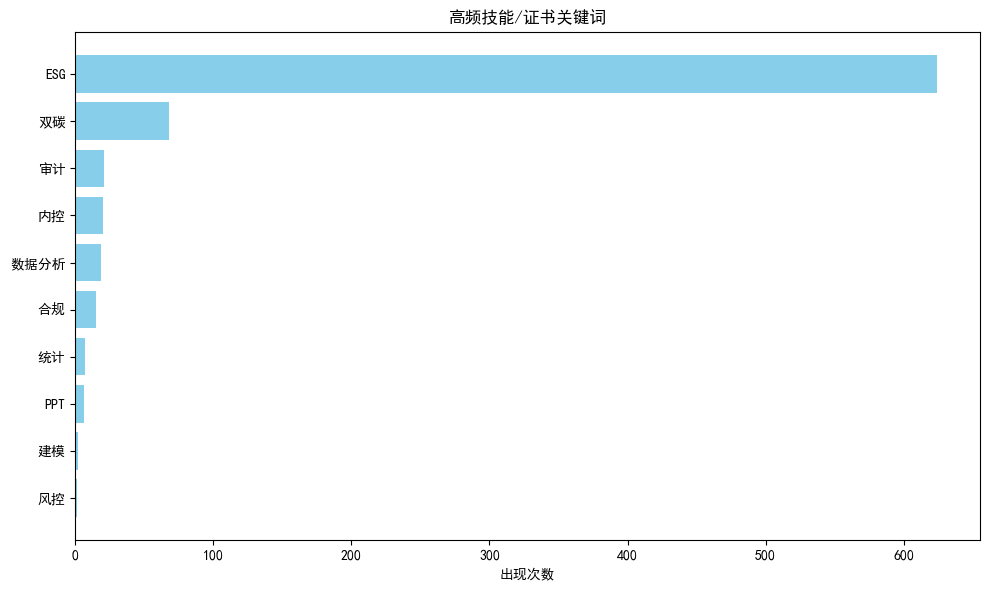

In [105]:
skills, freqs = zip(*skill_freq_sorted)

plt.figure(figsize=(10, 6))
plt.barh(skills, freqs, color='skyblue')
plt.xlabel("出现次数")
plt.title("高频技能/证书关键词")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**构建“人才画像**

In [110]:
skill_keywords = ['Python', 'Excel', '报告撰写', '数据分析', '建模', '风控', 'ESG', '碳管理']
cert_keywords = ['CFA', 'CPA', 'FRM', '中级会计师', '注册会计师', 'ESG认证']
edu_keywords = ['本科', '研究生', '硕士', '博士', '211', '985']
major_keywords = ['金融', '环境', '财务', '会计', '统计', '经济', '管理']
soft_keywords = ['沟通能力', '责任心', '团队合作', '逻辑思维', '抗压能力']
exp_keywords = ['经验', '从业', '背景', '优先', '实习', '项目']

In [112]:
def count_keywords(texts, keyword_list):
    all_text = ' '.join(texts)
    counts = Counter()
    for kw in keyword_list:
        if kw in all_text:
            counts[kw] = all_text.count(kw)
    return counts.most_common()


In [116]:
skills = count_keywords(texts, skill_keywords)
certs = count_keywords(texts, cert_keywords)
edu = count_keywords(texts, edu_keywords)
majors = count_keywords(texts, major_keywords)
softs = count_keywords(texts, soft_keywords)
exp = count_keywords(texts, exp_keywords)


In [118]:
print(" 核心技能:", [x[0] for x in skills if x[1] > 3])
print(" 教育要求:", [x[0] for x in edu if x[1] > 1])
print(" 专业背景:", [x[0] for x in majors if x[1] > 1])
print(" 证书要求:", [x[0] for x in certs if x[1] > 0])
print(" 软技能:", [x[0] for x in softs if x[1] > 0])
print(" 经验关键词:", [x[0] for x in exp if x[1] > 1])

 核心技能: ['ESG', '数据分析', '碳管理', '报告撰写']
 教育要求: ['博士', '本科', '研究生']
 专业背景: ['管理', '金融', '环境', '财务', '经济', '统计']
 证书要求: []
 软技能: ['沟通能力', '责任心', '团队合作']
 经验关键词: ['项目', '经验', '实习', '优先', '背景']
